# Test No-Memory Models on Temporal Networks

To test the models I check whether the constraints imposed are well reproduced.

In [58]:
from NaiveTCM import NaiveNetFitness
import Utilities
from PersistenceNetFitnessGlobal import PersistenceNetFitnessGlobal
from PersistenceNetFitness import PersistenceNetFitness
from PersistenceNetFitnesslinks import PersistenceNetFitnesslinks

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os

In [59]:
cd ../Structural Break and Reconstruction Social Networks/temporal_networks_daily

[Errno 2] No such file or directory: '../Structural Break and Reconstruction Social Networks/temporal_networks_daily'
/home/virginio.clemente/Structural Break and Reconstruction Social Networks/temporal_networks_daily


In [60]:
data = []

for file in os.listdir():
    if 'checkpoints' in file: continue
    step = int(file.split('_')[1].split('.')[0])
    matrix = np.genfromtxt(file,delimiter=',')
    G = nx.from_numpy_matrix(matrix)
    data.append([step , G ]) 

data.sort()

# Here I verify that all the models reproduce the constrained features

In [61]:
tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,50)

### Naive Configuration Model

In [62]:
pnt_likelihood_naive = NaiveNetFitness(tnet_synt_all)

x_cm =  pnt_likelihood_naive.solve_eq()

`gtol` termination condition is satisfied.
Function evaluations 11, initial cost 6.8604e+03, final cost 1.6198e-10, first-order optimality 3.58e-06.
`gtol` termination condition is satisfied.


In [63]:
k_exp =  np.zeros( pnt_likelihood_naive.no_nodes )
h_exp_cm =  np.zeros( pnt_likelihood_naive.no_nodes )
         
for i_node in range( pnt_likelihood_naive.no_nodes ):
    for j_node in range( pnt_likelihood_naive.no_nodes ):
        if i_node == j_node: 
            continue
            
        prod = x_cm[i_node] * x_cm[j_node ]
        k_exp[ i_node ] += prod / (1 + prod)

        h_exp_cm[ i_node ] += (prod / (1 + prod)) ** 2 

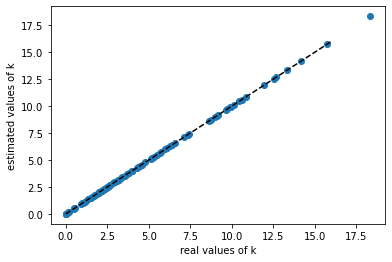

In [64]:
plt.xlabel('real values of k')
plt.ylabel('estimated values of k')
plt.scatter(k_exp,pnt_likelihood_naive.vec_k)
plt.plot([0, 16], [0, 16], ls="--", c="0")
plt.show()

### Dyadic Configuration Model

In this case the calculation is trivial, indeed the parameters are directly computed by inverting the following equaitons. 

All the equations are independent.

In [70]:
def average_link(data):
    
    matrices = []
    for time in range(len(data)):

        matrix = nx.to_numpy_array(data[time][1]) 

        matrices.append((matrix))
    
    average_matrix_sum = np.zeros(np.shape(matrices[0]))


    for time in range(len(matrices)):
        average_matrix_sum +=matrices[time]

    return average_matrix_sum/len(matrices)

In [71]:
ave_aij_matrix = average_link(data)

In [76]:
# Equations to compute the parameters
def compute_a_ij_x_ij(n_nodes,ave_aij_matrix):
    a_ij_list = []
    x_ij = []
    for i in range(n_nodes):
        for j in range(i):
            a_ij = ave_aij_matrix[i,j]
            a_ij_list.append(a_ij)
            x_ij.append(a_ij/(1-a_ij))
            
    return x_ij, a_ij_list

#This is the function used to compute the log-likelihood for the Dyadic Model
def CM_dyadic_likelihood(n_nodes,x_ij,a_ij):
    x_ij_lista = []

    for el in x_ij:
        if el == np.inf:
            x_ij_lista.append(0)
        elif el == 0:
            x_ij_lista.append(0)
        else:
            x_ij_lista.append(-np.log(el))
            
    termine_1 = [a_ij[ii] * x_ij_lista[ii]  for ii in range(len(a_ij)) ]
    
    termine_2 = 1
    ij = 0
    for i in range(n_nodes):
        for j in range(i):
            if x_ij[ij] != np.inf:
                termine_2 += np.log(1+x_ij[ij])
                ij += 1
            else:
                ij += 1 
                
    return (sum(termine_1)  - termine_2) 

In [77]:
x_ij,a_ij = compute_a_ij_x_ij(pnt_likelihood_naive.no_nodes,ave_aij_matrix)

likelihood_all = CM_dyadic_likelihood(pnt_likelihood_naive.no_nodes,x_ij,a_ij)

In [74]:
Utilities.AIC(likelihood_all,46*91)

8260.40011150734

### Global Contraint

In this case the lagrange multiplier is one and controls the value of the average degree

In [75]:
ave_k = np.sum(pnt_likelihood_naive.vec_k)/(pnt_likelihood_naive.no_nodes)

x_c_glob = ave_k/(pnt_likelihood_naive.no_nodes - 1 - ave_k)

# Here I start working with structural breaks Local CM

In [82]:
### Here I recall the set of equations to be solved for the Temporal CM

from numba import jit

def risolvi_eq(valori):
    @jit()
    def equations_to_solve(p, k):
        n_nodes = len(k)
        p = np.array(p)
        num_x_nonzero_nodes = np.count_nonzero(k)
        x_nonzero = p[0:num_x_nonzero_nodes]
        x = np.zeros(n_nodes)
        x[k != 0] = x_nonzero

        # Expected degrees
        k_exp = np.zeros(x.shape[0])

        for i in range(n_nodes):
            for j in range(n_nodes):
                if i == j:
                    continue
                k_exp[i] += (x[i] * x[j]) / (1 + x[i] * x[j])

        k_nonzero = k[k != 0]
        k_exp_nonzero = k_exp[k != 0]

        f1 = k_nonzero - k_exp_nonzero

        return np.asarray(f1)

    def numerically_solve_TN(vec_k):
        """
        Solves the TPCM numerically with least squares.
        """

        n_nodes = len(vec_k)

        # Rough estimate of initial values
        k = vec_k

        x_initial_values = np.random.rand(n_nodes)  # plus one to prevent dividing by zero np.sqrt(np.sum(k) + 1) * np.ones(self.no_nodes)

        x_initial_values = x_initial_values[k != 0]

        initial_values = x_initial_values
        boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
        x_solved = least_squares(fun=equations_to_solve,
                                 x0=initial_values,
                                 jac='2-point',
                                 args=(k,),
                                 bounds=boundslu,
                                 max_nfev=500,
                                 method='trf',
                                 loss='linear',
                                 tr_solver='exact',
                                 tr_options={},
                                 verbose=0,
                                 ftol=1e-5, xtol=1e-5, gtol=1e-5)


        p = x_solved.x
        p = np.array(p)
        num_x_nonzero_nodes = np.count_nonzero(k)
        x_nonzero = p[0:num_x_nonzero_nodes]
        x = np.zeros(n_nodes)
        x[k != 0] = x_nonzero

        x_array = x

        return x_array
    
    return numerically_solve_TN(valori)


# This is the likelihood of the CM
def likelihood_CM(vec_k,x):
    
    no_nodes = len(x)
    
    term1 = 0.
    term2 = 0.
    for i_node in range(no_nodes):
        if vec_k[i_node] == 0:continue
        term1 += vec_k[i_node] *np.log(x[i_node])

    for i_node in range(no_nodes):
        for j_node in range(i_node):
            term2 += np.log(1 + x[i_node] * x[j_node])

    likelihood = term1 - term2

    return  likelihood  

# Given a temporal network "tnet," this function returns the average degree associated with each node.
def compute_vec_k(tnet):
    
    no_steps = len(tnet.data)
    vec_k = np.zeros(tnet.no_nodes, dtype=np.float64)

    for i_step in range(no_steps):
        block_id, current_time, g = tnet.data[i_step]
        for [n1, n2] in g.edges():
            if n1 == n2: continue

            vec_k[int(n1)] += 1.
            vec_k[int(n2)] += 1.

    vec_k /= float(no_steps)
    return vec_k

In [84]:
import time
from scipy.optimize import least_squares

import warnings
warnings.filterwarnings("ignore")

def find_structural_breaks_CM(data,alfa_in):
    # Load the entire temporal network from the data
    tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))

    # Solve an equations for the entire network and find the parameters x_cm_all
    x_cm_all =  risolvi_eq(compute_vec_k(tnet_synt_all))

    # Calculate the likelihood for the whole network
    likelihood_CM_all = likelihood_CM(compute_vec_k(tnet_synt_all),x_cm_all)
    
    AIC_list = []
    
    # Calculate AIC for the entire network
    AIC_all = Utilities.AIC(likelihood_CM_all, len(x_cm_all))
    
    t_break = 0
    AIC_break = 0
    
    # Iterate over potential break points in the temporal data
    for t in range(3,len(data)-2):
        start_time = time.time()
        
        # Load two sub-networks, one before and one after the current time t
        tnet_synt_0 = Utilities.TemporalNetworkLoaderSynt(data,0,t)
        tnet_synt_1 = Utilities.TemporalNetworkLoaderSynt(data,t,len(data))

        # Solve equations for each sub-network
        x_cm_0 =  risolvi_eq(compute_vec_k(tnet_synt_0))
        x_cm_1 =  risolvi_eq(compute_vec_k(tnet_synt_1))
        
        # Calculate likelihood for each sub-network
        likelihood_CM_0 = likelihood_CM(compute_vec_k(tnet_synt_0),x_cm_0)
        likelihood_CM_1 = likelihood_CM(compute_vec_k(tnet_synt_1),x_cm_1)
        
        # Calculate the AIC difference between the combined sub-networks and the whole network
        AIC_diff = Utilities.AIC(likelihood_CM_0+likelihood_CM_1,len(x_cm_all)*2)
        AIC_to_check = AIC_diff - AIC_all
        
        AIC_list.append(AIC_to_check)
        
        # Update the break point if a lower AIC is found
        if AIC_to_check < 0:
            if AIC_to_check == -np.infty:
                continue
            
            if AIC_to_check < AIC_break:
                AIC_break = AIC_to_check
                t_break = t
                alfa_break = x_cm_0
                beta_break = 1

    # Return the AIC at the break point and the time of the break
    return AIC_break, t_break

### In summary, this function aims to iteratively divide a temporal network data series into increasingly smaller segments, identifying points where there is a significant change in the network's structure. This is done recursively until no further significant break points are found.

In [85]:
def recoursive_structural_detection(data,alfa):
    # Set initial break point to the length of the data
    t_break_final = len(data)
    
    # Call find_structural_breaks_CM to find the first structural break in the data
    prova_AIC, t_break = find_structural_breaks_CM(data,alfa)    
    
     # Check if no break was found
    if t_break == 0:
        # Return the length of the data as the final break point
        return t_break_final  
    else:
        try:
            # If a break is found, recursively call the function on the data up to the break point
            return recoursive_structural_detection(data[:t_break],alfa)
        except:
            # In case of an error, print an error message and return the last found break point
            print('error in the execution of recursive_structural_break', 'last t_break = ', t_break)
            return t_break

In [86]:
alfa_rand = np.random.rand(92) 

### Function used for detecting structural breaks using the model with node-level constraints.

In [87]:
tt = 0
t_vec_CM = [0]

while tt < len(data):

    t_break = recoursive_structural_detection(data[tt:],alfa_rand)

    tt += t_break
    t_vec_CM.append(tt)
    
print(t_vec_CM)

[0, 244]


In [89]:
AIC_all_cm = 0 # Initialize the total AIC to zero

# Iterate over each segment identified by the break points
for i in range(1,len(t_vec_CM)):
    
    # Load the network data for the current segment
    tnet_ = Utilities.TemporalNetworkLoaderSynt(data[t_vec_CM[i-1]:t_vec_CM[i]],0,len(data))

    # Solve the equations for the current segment
    x_cm_all =  risolvi_eq(compute_vec_k(tnet_))
    
    # Calculate the likelihood for the current segment
    likelihood_CM_all = likelihood_CM(compute_vec_k(tnet_),x_cm_all)
    
    # Compute the AIC for the current segment and add it to the total AIC
    AIC_all_cm += Utilities.AIC(likelihood_CM_all, len(x_cm_all))

# Print the total AIC for all segments
print(AIC_all_cm)

1657.1067483679324


# Dyadic Structural Breaks

In [92]:
import time

def find_structural_breaks_link_cm(data):
    
     # Load the entire temporal network from the data
    tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))
    
    n_nodes = tnet_synt_all.no_nodes
    
    ave_aij_matrix_all = average_link(data[0:len(data)])  
    x_ij_all,a_ij_all = compute_a_ij_x_ij(n_nodes,ave_aij_matrix_all)
    
    
    likelihood_all = CM_dyadic_likelihood(n_nodes,x_ij_all,a_ij_all)
    
    
    AIC_list = []
    
    AIC_all = Utilities.AIC(likelihood_all, 46*91)
    
    t_break = 0
    AIC_break = 0
    
    for t in range(3,len(data)-2):
        
        start_time = time.time()
        
        ave_aij_matrix_1 = average_link(data[0:t])
        ave_aij_matrix_0 = average_link(data[t:len(data)])
    
        x_ij_1,a_ij_1 = compute_a_ij_x_ij(n_nodes,ave_aij_matrix_1)
        x_ij_0,a_ij_0 = compute_a_ij_x_ij(n_nodes,ave_aij_matrix_0)
        
        likelihood_0 = CM_dyadic_likelihood(n_nodes,x_ij_0,a_ij_0)
        likelihood_1 = CM_dyadic_likelihood(n_nodes,x_ij_1,a_ij_1)

        
        AIC_diff = Utilities.AIC(likelihood_0+likelihood_1,(46*91)*2)
        AIC_to_check = AIC_diff - AIC_all
        
        AIC_list.append(AIC_to_check)
        if AIC_to_check < 0:
            if AIC_to_check == -np.infty:
                continue
            
            if AIC_to_check < AIC_break:
                AIC_break = AIC_to_check
                t_break = t

                print('Break at',t_break,AIC_break)
                
    return AIC_break, t_break

In [93]:
def recoursive_structural_detection_dyadic_cm(data):
    # Set initial break point to the length of the data
    t_break_final = len(data)
    
    # Call find_structural_breaks_link_cm to find the first structural break in the data
    prova_AIC, t_break = find_structural_breaks_link_cm(data)   
    
    # Check if no break was found
    if t_break == 0:
        # Return the length of the data as the final break point
        return t_break_final
    
    else:
        try:
            # If a break is found, recursively call the function on the data up to the break point
            return recoursive_structural_detection_dyadic_cm(data[:t_break])
        except:
            # In case of an error, print an error message and return the last found break point
            print('error in the execution of recursive_structural_break', 'last t_break = ', t_break)
            return 'errore'
        

In [94]:
tt = 0
t_vec_dyadic_cm = [0]
while tt < len(data):

    t_break = recoursive_structural_detection_dyadic_cm(data)
    
    if type(t_break) == str: 
        print(t_break)
        break
    tt += t_break
    t_vec_dyadic_cm.append(tt)

In [95]:
t_vec_dyadic_cm

[0, 244]

In [96]:
x_ij,a_ij = compute_a_ij_x_ij(pnt_likelihood_naive.no_nodes,ave_aij_matrix)

likelihood_all = CM_dyadic_likelihood(pnt_likelihood_naive.no_nodes,x_ij,a_ij)

Utilities.AIC(likelihood_all,46*91)

8260.40011150734

# Global Structural Breaks

In [30]:
def compute_likelihood_global_cm(no_nodes,vec_k):
    
    ave_k = np.sum(vec_k)/no_nodes

    x_c_glob = ave_k/(no_nodes -1-ave_k)

    ave_aij_matrix = average_link(data)

    termine_1 = 0
    termine_2 = 0

    for i in range(no_nodes):

        for j in range(i):


            termine_1 +=  np.log(x_c_glob) * ave_aij_matrix[i,j] # H
            termine_2 +=  np.log(1 + x_c_glob) 

    return termine_1 - termine_2 

In [31]:
tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))
likelihood_all = compute_likelihood_global_cm(tnet_synt_all.no_nodes,compute_vec_k(tnet_synt_all))


In [97]:
import time

def find_structural_breaks_global_cm(data):
    
    tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))
    
    likelihood_all = compute_likelihood_global_cm(tnet_synt_all.no_nodes,compute_vec_k(tnet_synt_all))
       
    AIC_list = []
    
    
    AIC_all = Utilities.AIC(likelihood_all,1)
    
    t_break = 0
    AIC_break = 0
    
    for t in range(3,len(data)-2):
        
        start_time = time.time()
        
        tnet_synt_0 = Utilities.TemporalNetworkLoaderSynt(data,0,t)        
        tnet_synt_1 = Utilities.TemporalNetworkLoaderSynt(data,t,len(data))


        likelihood_0 = compute_likelihood_global_cm(tnet_synt_0.no_nodes,compute_vec_k(tnet_synt_0))
        likelihood_1 = compute_likelihood_global_cm(tnet_synt_1.no_nodes,compute_vec_k(tnet_synt_1))

        
        AIC_diff = Utilities.AIC(likelihood_0+likelihood_1,2)        
        AIC_to_check = AIC_diff - AIC_all
        
        AIC_list.append(AIC_to_check)
        if AIC_to_check < 0:
            if AIC_to_check == -np.infty:
                continue
            
            if AIC_to_check < AIC_break:
                AIC_break = AIC_to_check
                t_break = t

                
    return AIC_break, t_break

In [98]:
def recoursive_structural_detection_global(data):
    
    t_break_final = len(data)
      
    prova_AIC, t_break = find_structural_breaks_global_cm(data)

    if t_break == 0:
        
        return t_break_final
    
    else:
        try:
            return recoursive_structural_detection_global(data[:t_break])
        except:
            print('error in the execution of recursive_structural_break', 'last t_break = ', t_break)
            return 'errore'
        

In [99]:
tt = 0
t_vec_global = [0]
while tt < len(data):

    t_break = recoursive_structural_detection_global(data[tt:])
    
    if type(t_break) == str: 
        #print(t_break)
        break
    tt += t_break
    t_vec_global.append(tt)

In [100]:
t_vec_global

[0, 244]

In [101]:
tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))
likelihood_all = compute_likelihood_global_cm(tnet_synt_all.no_nodes,compute_vec_k(tnet_synt_all))


Utilities.AIC(likelihood_all,1)

1716.39640546131